In [1]:
import os

In [2]:
data_dir = r"D:\DL_Keras_Book\jena_climate\\"
fname = os.path.join(data_dir + 'jena_climate_2009_2016.csv')

In [3]:
f = open(fname)
data = f.read()
f.close()

In [4]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [5]:
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [6]:
import numpy as np

In [7]:
float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,:] = values

In [8]:
import matplotlib.pyplot as plt

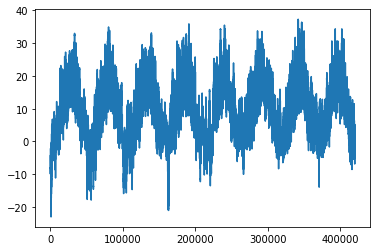

In [9]:
temp = float_data[:,1]
plt.plot(range(len(temp)), temp)

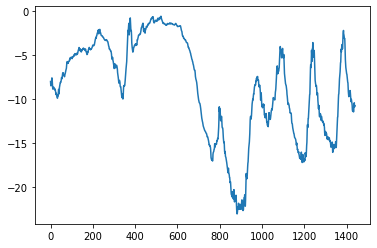

In [10]:
plt.plot(range(1440), temp[:1440])

In [11]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [12]:
def generator(data, lookback, delay, min_index, max_index, shuffle = False, batch_size = 128, step = 6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),lookback//step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j , row in enumerate(rows):
            indices = range(rows[j]-lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j]+delay][1]
        yield samples, targets

In [13]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [14]:
train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000,
                     shuffle=True, step=step, batch_size = batch_size)

In [15]:
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000,
                   batch_size=batch_size, step=step)

In [16]:
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, 
                    batch_size=batch_size, step=step)

In [17]:
val_steps = (300000 - 200001 - lookback)//batch_size
test_steps = (len(float_data) - 300001 - lookback)//batch_size

In [18]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

In [19]:
evaluate_naive_method()

0.2897359729905486


In [20]:
celsius_mae = 0.29 * std[1]

In [21]:
print(celsius_mae)

2.5672247338393395


In [22]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

D:\anaconda3\envs\Keras_DL_Book\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [23]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback//step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

In [24]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen,
                   validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 12s 22ms/step - loss: 1.3305 - val_loss: 0.5514
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 0.4641 - val_loss: 0.4134
Epoch 3/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2986 - val_loss: 0.3146
Epoch 4/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2684 - val_loss: 0.3138
Epoch 5/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2554 - val_loss: 0.3236
Epoch 6/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2460 - val_loss: 0.3172
Epoch 7/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2375 - val_loss: 0.3332
Epoch 8/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2313 - val_loss: 0.3152
Epoch 9/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2267 - val_loss: 0.3331
Epoch 10/20
500/500 [==============================] - 11s 22ms/step - loss: 0.222

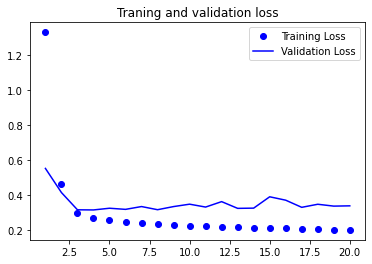

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure()

plt.plot(epochs, loss, 'bo', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title("Traning and validation loss")
plt.legend()

plt.show()

In [27]:
model = Sequential()
model.add(layers.GRU(32, input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [28]:
model.compile(optimizer=RMSprop(), loss = 'mae')

In [29]:
history = model.fit(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 56s 107ms/step - loss: 0.3127 - val_loss: 0.2732
Epoch 2/20
500/500 [==============================] - 55s 110ms/step - loss: 0.2843 - val_loss: 0.2717
Epoch 3/20
500/500 [==============================] - 55s 109ms/step - loss: 0.2783 - val_loss: 0.2658
Epoch 4/20
500/500 [==============================] - 54s 109ms/step - loss: 0.2726 - val_loss: 0.2611
Epoch 5/20
500/500 [==============================] - 54s 108ms/step - loss: 0.2681 - val_loss: 0.2635
Epoch 6/20
500/500 [==============================] - 55s 110ms/step - loss: 0.2638 - val_loss: 0.2678
Epoch 7/20
500/500 [==============================] - 54s 109ms/step - loss: 0.2577 - val_loss: 0.2638
Epoch 8/20
500/500 [==============================] - 54s 109ms/step - loss: 0.2534 - val_loss: 0.2671
Epoch 9/20
500/500 [==============================] - 54s 108ms/step - loss: 0.2483 - val_loss: 0.2709
Epoch 10/20
500/500 [==============================] - 55s 109ms/step - l

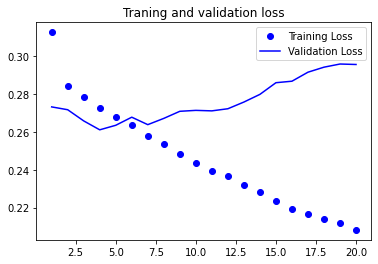

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure()

plt.plot(epochs, loss, 'bo', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title("Traning and validation loss")
plt.legend()

plt.show()

In [31]:
model = Sequential()
model.add(layers.GRU(32, dropout = 0.2, recurrent_dropout = 0.2, input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [32]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen,
                   validation_steps= val_steps)

Epoch 1/40
500/500 [==============================] - 81s 159ms/step - loss: 0.3228 - val_loss: 0.2781
Epoch 2/40
500/500 [==============================] - 81s 162ms/step - loss: 0.3074 - val_loss: 0.2737
Epoch 3/40
500/500 [==============================] - 81s 162ms/step - loss: 0.2999 - val_loss: 0.2714
Epoch 4/40
500/500 [==============================] - 81s 161ms/step - loss: 0.2963 - val_loss: 0.2920
Epoch 5/40
500/500 [==============================] - 81s 161ms/step - loss: 0.2910 - val_loss: 0.2797
Epoch 6/40
500/500 [==============================] - 80s 161ms/step - loss: 0.2864 - val_loss: 0.2749
Epoch 7/40
500/500 [==============================] - 80s 161ms/step - loss: 0.2815 - val_loss: 0.2819
Epoch 8/40
500/500 [==============================] - 82s 163ms/step - loss: 0.2785 - val_loss: 0.2774
Epoch 9/40
500/500 [==============================] - 80s 161ms/step - loss: 0.2742 - val_loss: 0.2763
Epoch 10/40
500/500 [==============================] - 120s 240ms/step - 

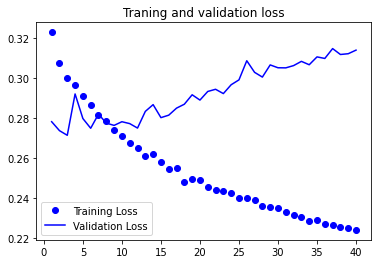

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure()

plt.plot(epochs, loss, 'bo', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title("Traning and validation loss")
plt.legend()

plt.show()

In [23]:
model = Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [24]:
model.compile(optimizer=RMSprop(), loss='mae')

In [25]:
history = model.fit(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen,
                   validation_steps= val_steps)

Epoch 1/40
500/500 [==============================] - 72s 138ms/step - loss: 0.3326 - val_loss: 0.2804
Epoch 2/40
500/500 [==============================] - 71s 142ms/step - loss: 0.3044 - val_loss: 0.2735
Epoch 3/40
500/500 [==============================] - 73s 146ms/step - loss: 0.2991 - val_loss: 0.2715
Epoch 4/40
500/500 [==============================] - 71s 143ms/step - loss: 0.2962 - val_loss: 0.2741
Epoch 5/40
500/500 [==============================] - 71s 142ms/step - loss: 0.2904 - val_loss: 0.2793
Epoch 6/40
500/500 [==============================] - 71s 143ms/step - loss: 0.2858 - val_loss: 0.2723
Epoch 7/40
500/500 [==============================] - 74s 148ms/step - loss: 0.2836 - val_loss: 0.2697
Epoch 8/40
500/500 [==============================] - 72s 144ms/step - loss: 0.2795 - val_loss: 0.2691
Epoch 9/40
500/500 [==============================] - 72s 144ms/step - loss: 0.2787 - val_loss: 0.2688
Epoch 10/40
500/500 [==============================] - 72s 143ms/step - l

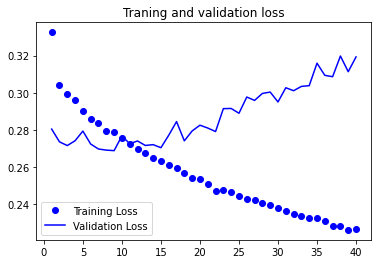

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure()

plt.plot(epochs, loss, 'bo', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title("Traning and validation loss")
plt.legend()

plt.show()

In [29]:
model = Sequential()
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True, input_shape = (None,float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

In [30]:
model.compile(optimizer=RMSprop(), loss='mae')

In [31]:
history = model.fit(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen,
                   validation_steps= val_steps)

Epoch 1/40
500/500 [==============================] - 215s 423ms/step - loss: 0.3206 - val_loss: 0.2842
Epoch 2/40
500/500 [==============================] - 211s 422ms/step - loss: 0.2996 - val_loss: 0.2766
Epoch 3/40
500/500 [==============================] - 212s 424ms/step - loss: 0.2943 - val_loss: 0.2709
Epoch 4/40
500/500 [==============================] - 474s 950ms/step - loss: 0.2866 - val_loss: 0.2741
Epoch 5/40
500/500 [==============================] - 207s 415ms/step - loss: 0.2796 - val_loss: 0.2682
Epoch 6/40
500/500 [==============================] - 208s 415ms/step - loss: 0.2722 - val_loss: 0.2692
Epoch 7/40
500/500 [==============================] - 208s 417ms/step - loss: 0.2705 - val_loss: 0.2765
Epoch 8/40
500/500 [==============================] - 206s 412ms/step - loss: 0.2651 - val_loss: 0.2725
Epoch 9/40
500/500 [==============================] - 206s 412ms/step - loss: 0.2604 - val_loss: 0.2776
Epoch 10/40
500/500 [==============================] - 206s 411m

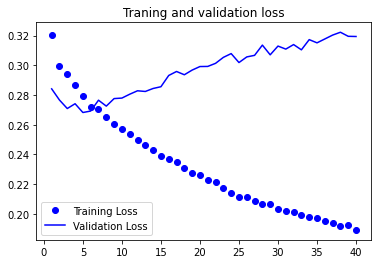

In [32]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure()

plt.plot(epochs, loss, 'bo', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title("Traning and validation loss")
plt.legend()

plt.show()

In [23]:
from keras.datasets import imdb

In [24]:
max_features = 10000
maxlen = 500

In [25]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

In [26]:
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

In [27]:
from keras.utils import pad_sequences

In [28]:
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [29]:
model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

In [30]:
model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics=['acc'])

In [31]:
history = model.fit(x_train, y_train, epochs=10, batch_size = 128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 49s 292ms/step - loss: 0.5083 - acc: 0.7604 - val_loss: 0.4309 - val_acc: 0.8286
Epoch 2/10
157/157 [==============================] - 45s 288ms/step - loss: 0.3247 - acc: 0.8779 - val_loss: 0.3660 - val_acc: 0.8718
Epoch 3/10
157/157 [==============================] - 48s 303ms/step - loss: 0.2581 - acc: 0.9042 - val_loss: 0.3432 - val_acc: 0.8734
Epoch 4/10
157/157 [==============================] - 47s 298ms/step - loss: 0.2185 - acc: 0.9228 - val_loss: 0.3276 - val_acc: 0.8746
Epoch 5/10
157/157 [==============================] - 49s 315ms/step - loss: 0.1926 - acc: 0.9311 - val_loss: 0.3706 - val_acc: 0.8754
Epoch 6/10
157/157 [==============================] - 53s 339ms/step - loss: 0.1708 - acc: 0.9396 - val_loss: 0.3587 - val_acc: 0.8786
Epoch 7/10
157/157 [==============================] - 50s 317ms/step - loss: 0.1521 - acc: 0.9466 - val_loss: 0.4501 - val_acc: 0.8774
Epoch 8/10
157/157 [==============================] - 4

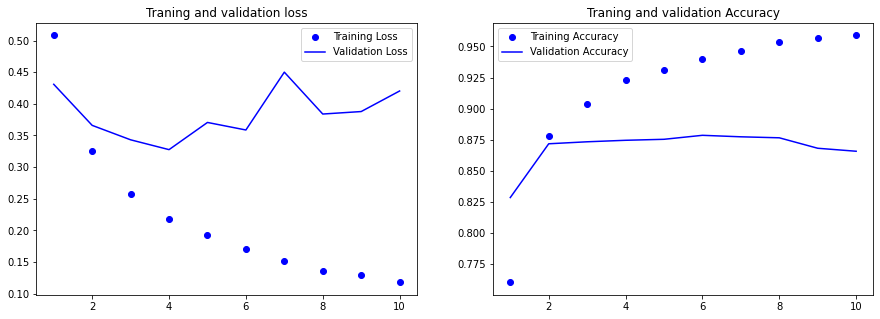

In [34]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss)+1)

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title("Traning and validation loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title("Traning and validation Accuracy")
plt.legend()

plt.show()

In [35]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

In [36]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [37]:
history = model.fit(x_train, y_train, epochs=10, batch_size = 128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 66s 406ms/step - loss: 0.5341 - acc: 0.7412 - val_loss: 0.3749 - val_acc: 0.8548
Epoch 2/10
157/157 [==============================] - 62s 392ms/step - loss: 0.3190 - acc: 0.8766 - val_loss: 0.3455 - val_acc: 0.8632
Epoch 3/10
157/157 [==============================] - 63s 401ms/step - loss: 0.2587 - acc: 0.9046 - val_loss: 0.3570 - val_acc: 0.8762
Epoch 4/10
157/157 [==============================] - 63s 403ms/step - loss: 0.2246 - acc: 0.9196 - val_loss: 0.3066 - val_acc: 0.8886
Epoch 5/10
157/157 [==============================] - 63s 400ms/step - loss: 0.1995 - acc: 0.9321 - val_loss: 0.3087 - val_acc: 0.8832
Epoch 6/10
157/157 [==============================] - 63s 400ms/step - loss: 0.1777 - acc: 0.9379 - val_loss: 0.4515 - val_acc: 0.8364
Epoch 7/10
157/157 [==============================] - 63s 399ms/step - loss: 0.1618 - acc: 0.9440 - val_loss: 0.3338 - val_acc: 0.8678
Epoch 8/10
157/157 [==============================] - 6

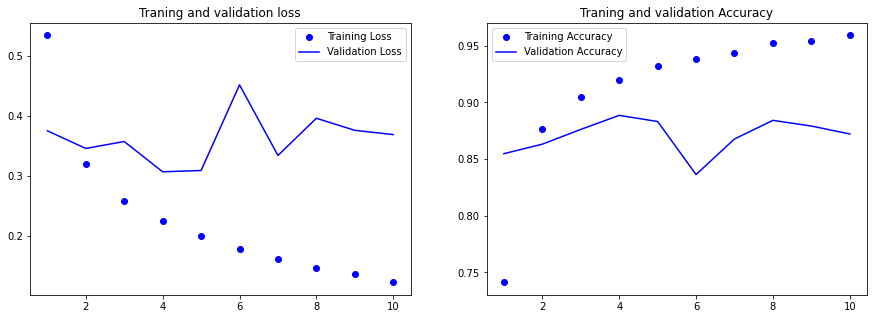

In [38]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss)+1)

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title("Traning and validation loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title("Traning and validation Accuracy")
plt.legend()

plt.show()

In [39]:
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [40]:
model.compile(optimizer=RMSprop(), loss='mae')

In [41]:
history = model.fit(train_gen, steps_per_epoch=500, epochs=40,
                   validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 71s 137ms/step - loss: 0.2921 - val_loss: 0.2685
Epoch 2/40
500/500 [==============================] - 78s 157ms/step - loss: 0.2734 - val_loss: 0.2653
Epoch 3/40
500/500 [==============================] - 76s 151ms/step - loss: 0.2687 - val_loss: 0.2672
Epoch 4/40
500/500 [==============================] - 74s 147ms/step - loss: 0.2624 - val_loss: 0.2674
Epoch 5/40
500/500 [==============================] - 75s 149ms/step - loss: 0.2559 - val_loss: 0.2673
Epoch 6/40
500/500 [==============================] - 76s 152ms/step - loss: 0.2503 - val_loss: 0.2664
Epoch 7/40
500/500 [==============================] - 76s 153ms/step - loss: 0.2433 - val_loss: 0.2718
Epoch 8/40
500/500 [==============================] - 77s 154ms/step - loss: 0.2376 - val_loss: 0.2756
Epoch 9/40
500/500 [==============================] - 77s 154ms/step - loss: 0.2302 - val_loss: 0.2846
Epoch 10/40
500/500 [==============================] - 76s 153ms/step - l

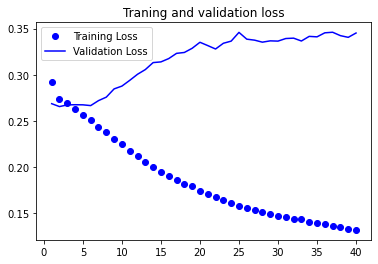

In [42]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure()

plt.plot(epochs, loss, 'bo', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title("Traning and validation loss")
plt.legend()

plt.show()

In [44]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape = (None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

In [45]:
model.compile(optimizer=RMSprop(), loss='mae')

In [46]:
history = model.fit(train_gen, steps_per_epoch=500, epochs=20,
                   validation_data= val_gen, validation_steps= val_steps)

Epoch 1/20
500/500 [==============================] - 20s 38ms/step - loss: 0.4104 - val_loss: 0.4600
Epoch 2/20
500/500 [==============================] - 20s 39ms/step - loss: 0.3556 - val_loss: 0.4445
Epoch 3/20
500/500 [==============================] - 19s 39ms/step - loss: 0.3316 - val_loss: 0.4611
Epoch 4/20
500/500 [==============================] - 18s 37ms/step - loss: 0.3161 - val_loss: 0.4519
Epoch 5/20
500/500 [==============================] - 18s 36ms/step - loss: 0.3043 - val_loss: 0.4718
Epoch 6/20
500/500 [==============================] - 18s 37ms/step - loss: 0.2950 - val_loss: 0.4695
Epoch 7/20
500/500 [==============================] - 23s 45ms/step - loss: 0.2875 - val_loss: 0.4696
Epoch 8/20
500/500 [==============================] - 19s 38ms/step - loss: 0.2795 - val_loss: 0.4686
Epoch 9/20
500/500 [==============================] - 19s 38ms/step - loss: 0.2748 - val_loss: 0.4885
Epoch 10/20
500/500 [==============================] - 19s 37ms/step - loss: 0.269

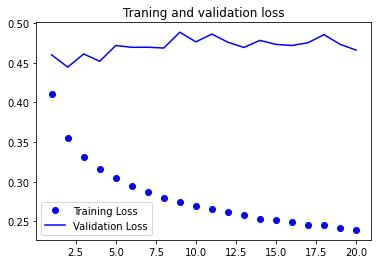

In [47]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure()

plt.plot(epochs, loss, 'bo', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title("Traning and validation loss")
plt.legend()

plt.show()

In [48]:
step = 3
lookback = 720
delay = 144

In [49]:
train_gen = generator(float_data, lookback = lookback, delay=delay, min_index = 0,
                      max_index = 200000, shuffle = True, step = step)
val_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 200001,
                   max_index = 300000, step = step)
test_gen = generator(float_data, lookback = lookback, delay=delay, min_index = 300001,
                    max_index = None, step = step)

In [50]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape = (None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

In [51]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, None, 32)          2272      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, None, 32)          5152      
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
__________________________________________________

In [52]:
model.compile(optimizer=RMSprop(), loss='mae')

In [53]:
history = model.fit(train_gen, steps_per_epoch=500, epochs=20,
                   validation_data=val_gen, validation_steps= val_steps)

Epoch 1/20
500/500 [==============================] - 39s 74ms/step - loss: 0.3306 - val_loss: 0.3465
Epoch 2/20
500/500 [==============================] - 37s 75ms/step - loss: 0.2969 - val_loss: 0.2821
Epoch 3/20
500/500 [==============================] - 38s 76ms/step - loss: 0.2832 - val_loss: 0.2711
Epoch 4/20
500/500 [==============================] - 38s 75ms/step - loss: 0.2732 - val_loss: 0.2770
Epoch 5/20
500/500 [==============================] - 37s 75ms/step - loss: 0.2656 - val_loss: 0.2904
Epoch 6/20
500/500 [==============================] - 37s 74ms/step - loss: 0.2596 - val_loss: 0.2811
Epoch 7/20
500/500 [==============================] - 39s 78ms/step - loss: 0.2537 - val_loss: 0.2792
Epoch 8/20
500/500 [==============================] - 38s 75ms/step - loss: 0.2464 - val_loss: 0.2842
Epoch 9/20
500/500 [==============================] - 38s 76ms/step - loss: 0.2419 - val_loss: 0.2847
Epoch 10/20
500/500 [==============================] - 38s 76ms/step - loss: 0.237

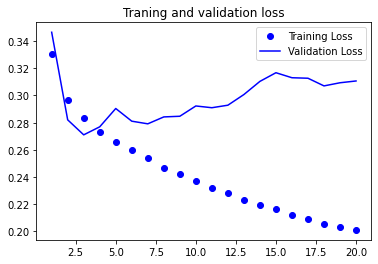

In [54]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure()

plt.plot(epochs, loss, 'bo', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.title("Traning and validation loss")
plt.legend()

plt.show()